<div class="alert alert-block alert-danger">
    
### Notes

</div>

###  Regression, Gradient descending, $ \ldots $.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from statsmodels.formula.api import ols

from scipy import stats

In [3]:
np.random.seed(1234)

<hr/>

<div class="alert alert-block alert-info">
Dataset
</div>

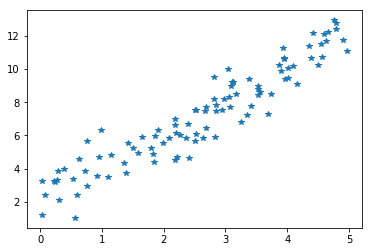

In [4]:
X = 5.0 * np.random.rand(100)
Y = 2*X + 2 + np.random.randn(100)

X_augmented = np.column_stack((np.ones(X.shape), X))

plt.plot(X,Y,'*');

#### Linear regression via explicit inverse

$ \mathbf{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T Y $

Betas:  [2.07630632 1.97652952]


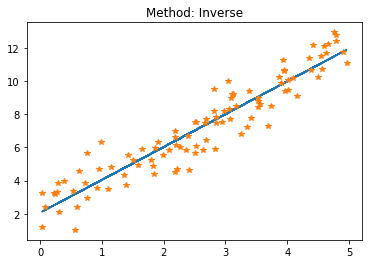

In [5]:
betas = np.linalg.inv(X_augmented.T @ X_augmented) @ X_augmented.T @ Y
print('Betas: ', betas)
plt.plot(X, betas[0] + betas[1]*X)
plt.title('Method: Inverse')
plt.plot(X,Y,'*');

##### Linear regression via batch gradient descent

$
\begin{align}
f(\mathbf{\beta}) &= \frac{1}{2} (\mathbf{X} \mathbf{\beta} - Y)^2 \\
&= \frac{1}{2} (\mathbf{X} \mathbf{\beta} - Y)^T (\mathbf{X} \mathbf{\beta} - Y) \\
&= \frac{1}{2} (\mathbf{\beta}^T \mathbf{X}^T - Y^T)(\mathbf{X} \mathbf{\beta} - Y) \\
&= \frac{1}{2} (\mathbf{\beta}^T \mathbf{X}^T \mathbf{X} \mathbf{\beta} - 2 Y^T \mathbf{X} \mathbf{\beta} + Y^T Y ) \\
\end{align}
$

$
\begin{align}
\frac{\partial{f}}{\partial\mathbf{\beta}} = \mathbf{\beta}^T \mathbf{X}^T \mathbf{X} - \mathbf{Y}^T \mathbf{X} \\
\end{align}
$

Centered differences: $\triangledown_{f(\beta)} \approx \frac{f(\beta + \Delta) - f(\beta - \Delta)}{2\Delta}$, as $\Delta \to 0$

Gradient descent $\beta_{i+1} := \beta_{i} - \eta \frac{\partial{f}}{\partial\beta}$

In [6]:
def batch_gradient_descent_analytical(beta_0, learning_rate, precision, max_iterations):

    next_beta = beta_0
    
    for i in range(max_iterations):
        curr_beta = next_beta
        next_beta = curr_beta - learning_rate*(curr_beta.T @ X_augmented.T @ X_augmented - Y.T @ X_augmented)
        if np.fabs(next_beta - curr_beta).all() < precision.all():
            print('Terminated at iteration: {}'.format(i))
            return next_beta
    
    print('Terminated. Max iterations reached.')
    return next_beta


def batch_gradient_descent_numerical(beta_0, learning_rate, precision, delta_epsilon, max_iterations):
    
    next_beta = beta_0
    
    for i in range(max_iterations):
        curr_beta = next_beta
        
        delta_full = np.full(2, delta_epsilon)
        curr_beta_fwd_diff = curr_beta + delta_full
        curr_beta_bwd_diff = curr_beta - delta_full
        
        fwd_diff = X_augmented @ curr_beta_fwd_diff - Y
        fwd_diff = fwd_diff @ fwd_diff
        
        bwd_diff = X_augmented @ curr_beta_bwd_diff - Y
        bwd_diff = bwd_diff @ bwd_diff
        
        next_beta = curr_beta - learning_rate * (fwd_diff - bwd_diff) / (2.0 * delta_epsilon)
        
        if np.fabs(next_beta - curr_beta).all() < precision.all():
            print('Terminated at iteration: {}'.format(i))
            return next_beta
        
    print('Terminated. Max iterations reached.')
    return next_beta


def stochastic_gradient_descent(beta_0, learning_rate, precision, max_iterations):
    
    next_beta = beta_0
    X_aug_shuffle = X_augmented.copy()
    
    for i in range(max_iterations):
        np.random.shuffle(X_aug_shuffle)
        for idx, r in enumerate(X_aug_shuffle):
            curr_beta = next_beta
            del_0 = 0.5 * (np.dot(curr_beta, r) - Y[idx])
            del_1 = del_0 * X_aug_shuffle[idx, 1]
            next_beta = curr_beta - learning_rate * np.array([del_0, del_1])
            if np.fabs(next_beta - curr_beta).all() < precision.all():
                print('Terminated at iteration: {}'.format(i))
                return next_beta   
    
    print('Terminated. Max iterations reached.')
    return next_beta 

Terminated. Max iterations reached.
Weights (analytical solution):  [1.08702987 2.28072568]
Terminated at iteration: 169
Weights (numerical solution):  [2.0007191 2.0007191]
Terminated. Max iterations reached.
Weights (stochastic gradient descent solution):  [1.55300403 1.73433469]


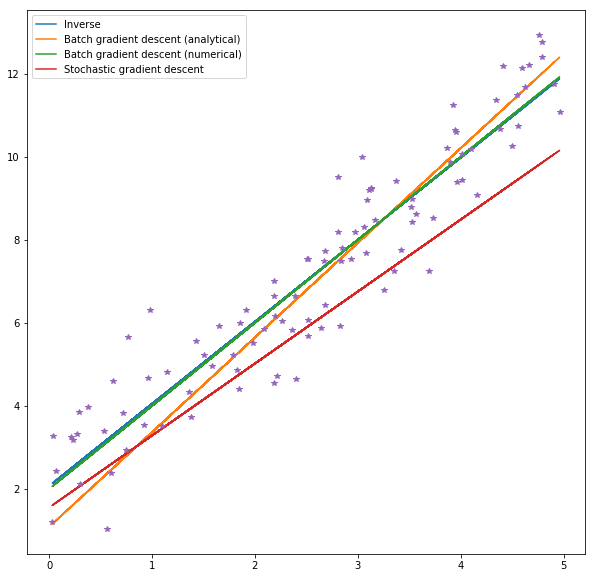

In [7]:
beta_0 = np.zeros(2)
learning_rate = 0.00005
precision_ = np.full(2, 0.000001)
max_iterations = 300

betas_agd = batch_gradient_descent_analytical(beta_0, learning_rate, precision_, max_iterations)
print('Weights (analytical solution): ', betas_agd)

delta_epsilon = 0.000001
betas_ngd = batch_gradient_descent_numerical(beta_0, learning_rate, precision_, delta_epsilon, max_iterations)
print('Weights (numerical solution): ', betas_ngd)

betas_sgd = stochastic_gradient_descent(beta_0, learning_rate, precision_, max_iterations)
print('Weights (stochastic gradient descent solution): ', betas_sgd)

plt.figure(figsize=(10,10))
plt.plot(X, betas[0] + betas[1]*X)
plt.plot(X, betas_agd[0] + betas_agd[1]*X)
plt.plot(X, betas_ngd[0] + betas_ngd[1]*X)
plt.plot(X, betas_sgd[0] + betas_sgd[1]*X)
plt.legend(['Inverse', 'Batch gradient descent (analytical)', 'Batch gradient descent (numerical)', 'Stochastic gradient descent'])
plt.plot(X,Y,'*');

<hr/>

### Regularization

#### Ridge regression (coefficients shrinkage)

$\text{argmin}_{\forall \beta} \{ \mid\mid \mathbf{Y} - \mathbf{X}\mathbf{\beta} \mid\mid_{2} + w\mid\mid \mathbf{\beta} \mid\mid_{2} \}$, $w \ge 0$

<hr/>

#### Lasso (least absolute shrinkage and selection operator)

$\text{argmin}_{\forall \beta} \{ \mid\mid \mathbf{Y} - \mathbf{X}\mathbf{\beta} \mid\mid_{2} + w\mid\mid \mathbf{\beta} \mid\mid_{1} \}$, $w \ge 0$

- (constrain with $L_1$ norm instead of Euclidean $L_2$ norm)